In [2]:

import sys
sys.path.insert(1,"/home1/07064/tg863631/anaconda3/envs/CbrainCustomLayer/lib/python3.6/site-packages") #work around for h5py
from cbrain.imports import *
from cbrain.cam_constants import *
from cbrain.utils import *
from cbrain.layers import *
from cbrain.data_generator import DataGenerator
import tensorflow as tf
from tensorflow import math as tfm
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import tensorflow_probability as tfp
import xarray as xr
import numpy as np
from cbrain.model_diagnostics import ModelDiagnostics
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as imag
import scipy.integrate as sin
import matplotlib.ticker as mticker
import pickle
from tensorflow.keras import layers
import datetime
from cbrain.climate_invariant import *
import yaml


## Global Variables

In [3]:
# Load coordinates (just pick any file from the climate model run)
coor = xr.open_dataset("/oasis/scratch/comet/ankitesh/temp_project/data/sp8fbp_minus4k.cam2.h1.0000-01-01-00000.nc",\
                    decode_times=False)
lat = coor.lat; lon = coor.lon; lev = coor.lev;
coor.close();

In [4]:
TRAINDIR = '/oasis/scratch/comet/ankitesh/temp_project/PrepData/CRHData/'
path = '/home/ankitesh/CBrain_project/CBRAIN-CAM/cbrain/'
path_hyam = 'hyam_hybm.pkl'

hf = open(path+path_hyam,'rb')
hyam,hybm = pickle.load(hf)
scale_dict = load_pickle('/home/ankitesh/CBrain_project/CBRAIN-CAM/nn_config/scale_dicts/009_Wm2_scaling.pkl')


## Data Generators

These will be fed to the models during training

### Data Generator using RH

In [5]:
scale_dict_RH = load_pickle('/home/ankitesh/CBrain_project/CBRAIN-CAM/nn_config/scale_dicts/009_Wm2_scaling.pkl')
scale_dict_RH['RH'] = 0.01*L_S/G, # Arbitrary 0.1 factor as specific humidity is generally below 2%

in_vars_RH = ['RH','TBP','PS', 'SOLIN', 'SHFLX', 'LHFLX']
out_vars_RH = ['PHQ','TPHYSTND','FSNT', 'FSNS', 'FLNT', 'FLNS']

TRAINFILE_RH = 'CI_RH_M4K_NORM_train_shuffle.nc'
NORMFILE_RH = 'CI_RH_M4K_NORM_norm.nc'
VALIDFILE_RH = 'CI_RH_M4K_NORM_valid.nc'

In [6]:
train_gen_RH = DataGenerator(
    data_fn = '/oasis/scratch/comet/ankitesh/temp_project/PrepData/'+TRAINFILE_RH,
    input_vars = in_vars_RH,
    output_vars = out_vars_RH,
    norm_fn = '/oasis/scratch/comet/ankitesh/temp_project/PrepData/'+NORMFILE_RH,
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict_RH,
    batch_size=1024,
    shuffle=True,
    normalize_flag=True
)

#### For positive sepearation (required only when scaling is included)

In [7]:
TRAINFILE_RH = 'PosCRH_CI_RH_M4K_NORM_train_shuffle.nc'
NORMFILE_RH = 'PosCRH_CI_RH_M4K_NORM_norm.nc'

train_gen_RH_pos = DataGenerator(
    data_fn = TRAINDIR+TRAINFILE_RH,
    input_vars = in_vars_RH,
    output_vars = out_vars_RH,
    norm_fn = TRAINDIR+NORMFILE_RH,
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict_RH,
    batch_size=1024,
    shuffle=True,
    normalize_flag=True
)

#### For negative sepearation

In [8]:
TRAINFILE_RH = 'NegCRH_CI_RH_M4K_NORM_train_shuffle.nc'
NORMFILE_RH = 'NegCRH_CI_RH_M4K_NORM_norm.nc'

train_gen_RH_neg = DataGenerator(
    data_fn = TRAINDIR+TRAINFILE_RH,
    input_vars = in_vars_RH,
    output_vars = out_vars_RH,
    norm_fn = TRAINDIR+NORMFILE_RH,
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict_RH,
    batch_size=1024,
    shuffle=True,
    normalize_flag=True
)

### Data Generator using TNS

In [9]:
in_vars = ['QBP','TfromNS','PS', 'SOLIN', 'SHFLX', 'LHFLX']
out_vars = ['PHQ','TPHYSTND','FSNT', 'FSNS', 'FLNT', 'FLNS']

TRAINFILE_TNS = 'CI_TNS_M4K_NORM_train_shuffle.nc'
NORMFILE_TNS = 'CI_TNS_M4K_NORM_norm.nc'
VALIDFILE_TNS = 'CI_TNS_M4K_NORM_valid.nc'

In [10]:
train_gen_TNS = DataGenerator(
    data_fn = '/oasis/scratch/comet/ankitesh/temp_project/PrepData/'+TRAINFILE_TNS,
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = '/oasis/scratch/comet/ankitesh/temp_project/PrepData/'+NORMFILE_TNS,
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict,
    batch_size=1024,
    shuffle=True,
    normalize_flag=True
)

#### For positive

In [11]:
TRAINFILE_TNS = 'PosCRH_CI_TNS_M4K_NORM_train_shuffle.nc'
NORMFILE_TNS = 'PosCRH_CI_TNS_M4K_NORM_norm.nc'

train_gen_TNS_pos = DataGenerator(
    data_fn = TRAINDIR+TRAINFILE_TNS,
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = TRAINDIR+NORMFILE_TNS,
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict,
    batch_size=1024,
    shuffle=True,
    normalize_flag=True
)

#### For negative

In [12]:
TRAINFILE_TNS = 'NegCRH_CI_TNS_M4K_NORM_train_shuffle.nc'
NORMFILE_TNS = 'NegCRH_CI_TNS_M4K_NORM_norm.nc'

train_gen_TNS_neg = DataGenerator(
    data_fn = TRAINDIR+TRAINFILE_TNS,
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = TRAINDIR+NORMFILE_TNS,
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict,
    batch_size=1024,
    shuffle=True,
    normalize_flag=True
)

## Data Generator Combined

In [13]:
in_vars = ['QBP','TBP','PS', 'SOLIN', 'SHFLX', 'LHFLX']
out_vars = ['PHQ','TPHYSTND','FSNT', 'FSNS', 'FLNT', 'FLNS']

**Note:** we will be training two models - 1 would be brute force and the other would be the whole climate invariant network.  
Depeneding on your requrement you can toggle the transformation flag using the below data generator

#### Data generator for bruteforce network

In [14]:
## this won't be used just to show we can use it overall
TRAINFILE = 'CI_SP_M4K_train_shuffle.nc'
NORMFILE = 'CI_SP_M4K_NORM_norm.nc'
VALIDFILE = 'CI_SP_M4K_valid.nc'

train_gen_bf = DataGeneratorClimInv(
    data_fn = '/oasis/scratch/comet/ankitesh/temp_project/PrepData/'+TRAINFILE,
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = '/oasis/scratch/comet/ankitesh/temp_project/PrepData/'+NORMFILE,
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict,
    batch_size=1024,
    shuffle=True,
    normalize_flag=True,
    lev=lev,
    hyam=hyam,hybm=hybm,
    inp_subRH=train_gen_RH.input_transform.sub, inp_divRH=train_gen_RH.input_transform.div,
    inp_subTNS=train_gen_TNS.input_transform.sub,inp_divTNS=train_gen_TNS.input_transform.div,
    rh_trans = False,t2tns_trans=False,
    lhflx_trans=False,
    scaling=False,
    interpolate=False
)

valid_gen_bf = DataGeneratorClimInv(
    data_fn = '/oasis/scratch/comet/ankitesh/temp_project/PrepData/'+VALIDFILE,
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = '/oasis/scratch/comet/ankitesh/temp_project/PrepData/'+NORMFILE,
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict,
    batch_size=1024,
    shuffle=True,
    normalize_flag=True,
    lev=lev,
    hyam=hyam,hybm=hybm,
    inp_subRH=train_gen_RH.input_transform.sub, inp_divRH=train_gen_RH.input_transform.div,
    inp_subTNS=train_gen_TNS.input_transform.sub,inp_divTNS=train_gen_TNS.input_transform.div,
    rh_trans = False,t2tns_trans=False,
    lhflx_trans=False,
    scaling=False,
    interpolate=False
)




#### For positive (for the whole network)

In [15]:
TRAINFILE = 'PosCRH_CI_SP_M4K_train_shuffle.nc'
NORMFILE = 'PosCRH_CI_SP_M4K_NORM_norm.nc'
VALIDFILE = 'PosCRH_CI_SP_M4K_valid.nc'

train_gen_pos = DataGeneratorClimInv(
    data_fn = TRAINDIR+TRAINFILE,
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = TRAINDIR+NORMFILE,
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict,
    batch_size=1024,
    shuffle=True,
    normalize_flag=True,
    lev=lev,
    hyam=hyam,hybm=hybm,
    inp_subRH=train_gen_RH_pos.input_transform.sub, inp_divRH=train_gen_RH_pos.input_transform.div,
    inp_subTNS=train_gen_TNS_pos.input_transform.sub,inp_divTNS=train_gen_TNS_pos.input_transform.div
)

valid_gen_pos = DataGeneratorClimInv(
    data_fn = TRAINDIR+VALIDFILE,
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = TRAINDIR+NORMFILE,
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict,
    batch_size=1024,
    shuffle=True,
    normalize_flag=True,
    lev=lev,
    hyam=hyam,hybm=hybm,
    inp_subRH=train_gen_RH_pos.input_transform.sub, inp_divRH=train_gen_RH_pos.input_transform.div,
    inp_subTNS=train_gen_TNS_pos.input_transform.sub,inp_divTNS=train_gen_TNS_pos.input_transform.div
)

#### For Negative (We don't scale the negative network)

In [16]:
TRAINFILE = 'NegCRH_CI_SP_M4K_train_shuffle.nc'
NORMFILE = 'NegCRH_CI_SP_M4K_NORM_norm.nc'
VALIDFILE = 'NegCRH_CI_SP_M4K_valid.nc'

### we don't scale this network
train_gen_neg = DataGeneratorClimInv(
    data_fn = TRAINDIR+TRAINFILE,
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = TRAINDIR+NORMFILE,
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict,
    batch_size=1024,
    shuffle=True,
    normalize_flag=True,
    lev=lev,
    hyam=hyam,hybm=hybm,
    inp_subRH=train_gen_RH_neg.input_transform.sub, inp_divRH=train_gen_RH_neg.input_transform.div,
    inp_subTNS=train_gen_TNS_neg.input_transform.sub,inp_divTNS=train_gen_TNS_neg.input_transform.div,
    scaling=False
)

valid_gen_neg = DataGeneratorClimInv(
    data_fn = TRAINDIR+VALIDFILE,
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = TRAINDIR+NORMFILE,
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict,
    batch_size=1024,
    shuffle=True,
    normalize_flag=True,
    lev=lev,
    hyam=hyam,hybm=hybm,
    inp_subRH=train_gen_RH_neg.input_transform.sub, inp_divRH=train_gen_RH_neg.input_transform.div,
    inp_subTNS=train_gen_TNS_neg.input_transform.sub,inp_divTNS=train_gen_TNS_neg.input_transform.div,
    scaling=False
)

## Diagnostics

In [17]:
path_HDF5 = '/oasis/scratch/comet/ankitesh/temp_project/models/modelsAquaplanet/' # Path to NN weights
config_file = 'CI_SP_M4K_CONFIG.yml' # Configuration file
data_file = ['CI_SP_M4K_valid.nc','CI_SP_P4K_valid.nc']  # Validation/test data sets
NNarray = ['RH_TNS_LH.hdf5','RH_TNS_LH_ScalePos_Interp.hdf5*RH_TNS_LH_ScaleNeg_Interp.hdf5'] # NN to evaluate 
NNname = ['RH-TNS-LH','RH-TNS-LH-Scaling-Interp'] # Name of NNs for plotting
dict_lay = {'SurRadLayer':SurRadLayer,'MassConsLayer':MassConsLayer,'EntConsLayer':EntConsLayer,
            'QV2RH':QV2RH,'T2TmTNS':T2TmTNS,'eliq':eliq,'eice':eice,'esat':esat,'qv':qv,'RH':RH,
           'reverseInterpLayer':reverseInterpLayer,'ScaleOp':ScaleOp}

In [18]:
# Indices of different variables
PHQ_idx = slice(0,30)
TPHYSTND_idx = slice(30,60)


In [19]:

#define default values


NN = {}; md = {};
%cd $TRAINDIR/HDF5_DATA
for i,NNs in enumerate(NNarray):
    print('NN name is ',NNs)
    path = path_HDF5+NNs
    
    rh_trans=False
    t2tns_trans=False
    lhflx_trans=False
    scaling=False
    interpolate=False
    model = path
    pos_model=None
    neg_model=None
    if 'RH' in NNs:
        rh_trans=True
    if 'TNS' in NNs:
        t2tns_trans=True
    if 'LH' in NNs:
        lhflx_trans=True
        
    if 'Scal' in NNs:
        pos,neg = NNs.split('*')
        pos_model = path_HDF5+pos
        neg_model = path_HDF5+neg
        model = None
        scaling=True
    if 'Interp' in NNs or 'Vert' in NNs:
        interpolate=True
        
    md[NNs] = {}
    for j,data in enumerate(data_file):
        print('data name is ',data)
        
        NN[NNs] = load_climate_model(dict_lay,'/home/ankitesh/CBrain_project/PrepData/'+config_file,
                                     '/oasis/scratch/comet/ankitesh/temp_project/PrepData/'+data,
                                     lev=lev,hyam=hyam,hybm=hybm,TRAINDIR=TRAINDIR,
                                     inp_subRH=train_gen_RH.input_transform.sub, inp_divRH=train_gen_RH.input_transform.div,
                                     inp_subTNS=train_gen_TNS.input_transform.sub,inp_divTNS=train_gen_TNS.input_transform.div,
                                     rh_trans=rh_trans,t2tns_trans=t2tns_trans,
                                     lhflx_trans=lhflx_trans,scaling=scaling,interpolate=interpolate,
                                     model=model,pos_model=pos_model,neg_model=neg_model,
                                      train_gen_RH_pos=train_gen_RH_pos,train_gen_RH_neg=train_gen_RH_neg,
                                        train_gen_TNS_pos=train_gen_TNS_pos,train_gen_TNS_neg=train_gen_TNS_neg  )
        
        md[NNs][data[6:-3]] = ModelDiagnostics(NN[NNs],
                                                '/home/ankitesh/CBrain_project/PrepData/'+config_file,
                                                '/oasis/scratch/comet/ankitesh/temp_project/PrepData/'+data)
        


[Errno 2] No such file or directory: '/oasis/scratch/comet/ankitesh/temp_project/PrepData/CRHData//HDF5_DATA'
/home/ankitesh/CBRAIN-CAM/notebooks/ankitesh-devlog
NN name is  RH_TNS_LH.hdf5
data name is  CI_SP_M4K_valid.nc


/home/ankitesh/CBRAIN-CAM/notebooks/ankitesh-devlog/cbrain/climate_invariant.py:843: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)
/home/ankitesh/CBRAIN-CAM/notebooks/ankitesh-devlog/cbrain/model_diagnostics.py:30: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)
/home/ankitesh/CBRAIN-CAM/notebooks/ankitesh-devlog/cbrain/climate_invariant.py:843: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


data name is  CI_SP_P4K_valid.nc


/home/ankitesh/CBRAIN-CAM/notebooks/ankitesh-devlog/cbrain/model_diagnostics.py:30: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)
/home/ankitesh/CBRAIN-CAM/notebooks/ankitesh-devlog/cbrain/climate_invariant.py:843: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


NN name is  RH_TNS_LH_ScalePos_Interp.hdf5*RH_TNS_LH_ScaleNeg_Interp.hdf5
data name is  CI_SP_M4K_valid.nc


/home/ankitesh/CBRAIN-CAM/notebooks/ankitesh-devlog/cbrain/model_diagnostics.py:30: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)
/home/ankitesh/CBRAIN-CAM/notebooks/ankitesh-devlog/cbrain/climate_invariant.py:843: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


data name is  CI_SP_P4K_valid.nc


/home/ankitesh/CBRAIN-CAM/notebooks/ankitesh-devlog/cbrain/model_diagnostics.py:30: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


In [20]:
lat_ind = np.arange(26,40)
iinis = [500]

diagno = {} # Diagnostics structure
diagno['truth'] = {} # Diagnostics structure for the truth
diagno['truth_pos'] = {} # Diagnostics structure for the truth pos
diagno['truth_neg'] = {} # Diagnostics structure for the truth neg
truth_done = {}

for j,data in enumerate(data_file):
    truth_done[data[6:-3]] = False

for i,NNs in enumerate(NNarray):
    print('i=',i,'& NNs=',NNs,'         ')
    diagno[NNs] = {} # Diagnostics structure for each NN
    for j,data in enumerate(data_file):
        diagno[NNs][data[6:-3]]={}
        if i==0: 
            diagno['truth'][data[6:-3]]={}
            diagno['truth_pos'][data[6:-3]]={}
            diagno['truth_neg'][data[6:-3]]={}
        for iini in iinis:
            
            print('j=',j,'& iini=',iini,'& data=',data,'         ',end='\r'),
            
            iend = iini+47
            diagno[NNs][data[6:-3]][iini] = {} # Diagnostics structure for each data file
            if i==0: 
                diagno['truth'][data[6:-3]][iini] = {}
                diagno['truth_pos'][data[6:-3]][iini] = {}
                diagno['truth_neg'][data[6:-3]][iini] = {}
                
            for itime in tqdm(np.arange(iini,iend)):
                # Get input, prediction and truth from NN
                inp, p, truth = md[NNs][data[6:-3]].get_inp_pred_truth(itime)  # [lat, lon, var, lev]
                ## only if the scaling is true
                if NN[NNs].scaling==True:
                    X, _ = md[NNs][data[6:-3]].valid_gen[itime]
                    mask, pos_op, neg_op = md[NNs][data[6:-3]].model.predict_on_batch_seperate(X.values)
                    mask_reshaped = md[NNs][data[6:-3]].reshape_ngeo(mask)[lat_ind,:,:]
                    mask = mask_reshaped.flatten()
                    neg_mask = np.logical_not(mask)
                    ## get the truth only once.
                p = np.array(p)
                # Get convective heating and moistening for each NN
                if itime==iini:
                    if i==0:
                        diagno['truth'][data[6:-3]][iini]['PHQ'] = md[NNs][data[6:-3]].reshape_ngeo(truth[:,PHQ_idx])[lat_ind,:,:,np.newaxis]
                        diagno['truth'][data[6:-3]][iini]['TPHYSTND'] = md[NNs][data[6:-3]].reshape_ngeo(truth[:,TPHYSTND_idx])[lat_ind,:,:,np.newaxis]
                    ##if scaling is true and the truth array is not filled
                    if NN[NNs].scaling==True and truth_done[data[6:-3]]==False:
                        diagno['truth_pos'][data[6:-3]][iini]['PHQ_pos'] = md[NNs][data[6:-3]].reshape_ngeo(truth[:,PHQ_idx])[lat_ind,:,:].reshape(-1,30)[mask]
                        diagno['truth_pos'][data[6:-3]][iini]['TPHYSTND_pos'] = md[NNs][data[6:-3]].reshape_ngeo(truth[:,TPHYSTND_idx])[lat_ind,:,:].reshape(-1,30)[mask]
                        diagno['truth_neg'][data[6:-3]][iini]['PHQ_neg'] = md[NNs][data[6:-3]].reshape_ngeo(truth[:,PHQ_idx])[lat_ind,:,:].reshape(-1,30)[neg_mask]
                        diagno['truth_neg'][data[6:-3]][iini]['TPHYSTND_neg'] = md[NNs][data[6:-3]].reshape_ngeo(truth[:,TPHYSTND_idx])[lat_ind,:,:].reshape(-1,30)[neg_mask]
                        truth_done[data[6:-3]] = True
                                                    
                    diagno[NNs][data[6:-3]][iini]['PHQ'] = md[NNs][data[6:-3]].reshape_ngeo(p[:,PHQ_idx])[lat_ind,:,:,np.newaxis]
                    diagno[NNs][data[6:-3]][iini]['TPHYSTND'] = md[NNs][data[6:-3]].reshape_ngeo(p[:,TPHYSTND_idx])[lat_ind,:,:,np.newaxis]
                    if NN[NNs].scaling==True:
                        diagno[NNs][data[6:-3]][iini]['PHQ_pos'] = md[NNs][data[6:-3]].reshape_ngeo(p[:,PHQ_idx])[lat_ind,:,:].reshape(-1,30)[mask]
                        diagno[NNs][data[6:-3]][iini]['TPHYSTND_pos'] = md[NNs][data[6:-3]].reshape_ngeo(p[:,TPHYSTND_idx])[lat_ind,:,:].reshape(-1,30)[mask]
                        diagno[NNs][data[6:-3]][iini]['PHQ_neg'] = md[NNs][data[6:-3]].reshape_ngeo(p[:,PHQ_idx])[lat_ind,:,:].reshape(-1,30)[neg_mask]
                        diagno[NNs][data[6:-3]][iini]['TPHYSTND_neg'] = md[NNs][data[6:-3]].reshape_ngeo(p[:,TPHYSTND_idx])[lat_ind,:,:].reshape(-1,30)[neg_mask]

                else:
                    for istr,field in enumerate(['PHQ','TPHYSTND']):
                        if field=='PHQ': ind_field = PHQ_idx
                        elif field=='TPHYSTND': ind_field = TPHYSTND_idx
                        diagno[NNs][data[6:-3]][iini][field] = np.concatenate((diagno[NNs][data[6:-3]][iini][field],
                                                             md[NNs][data[6:-3]].\
                                                             reshape_ngeo(p[:,ind_field])[lat_ind,:,:,np.newaxis]),
                                                            axis=3)
                        if NN[NNs].scaling==True:
                            diagno[NNs][data[6:-3]][iini][field+'_pos'] = np.concatenate((diagno[NNs][data[6:-3]][iini][field+'_pos'],
                                         md[NNs][data[6:-3]].\
                                         reshape_ngeo(p[:,ind_field])[lat_ind,:,:].reshape(-1,30)[mask]),
                                        axis=0)

                            diagno[NNs][data[6:-3]][iini][field+'_neg'] = np.concatenate((diagno[NNs][data[6:-3]][iini][field+'_neg'],
                                         md[NNs][data[6:-3]].\
                                         reshape_ngeo(p[:,ind_field])[lat_ind,:,:].reshape(-1,30)[neg_mask]),
                                        axis=0)
                        if i==0:
                            diagno['truth'][data[6:-3]][iini][field] = np.concatenate((diagno['truth'][data[6:-3]][iini][field],
                                                                     md[NNs][data[6:-3]].\
                                                                     reshape_ngeo(truth[:,ind_field])[lat_ind,:,:,np.newaxis]),
                                                                    axis=3)
                            
                            if NN[NNs].scaling==True:
                                diagno['truth_pos'][data[6:-3]][iini][field+'_pos'] = np.concatenate((diagno['truth_pos'][data[6:-3]][iini][field+'_pos'],
                                             md[NNs][data[6:-3]].\
                                             reshape_ngeo(truth[:,ind_field])[lat_ind,:,:].reshape(-1,30)[mask]),
                                            axis=0)
                                diagno['truth_neg'][data[6:-3]][iini][field+'_neg'] = np.concatenate((diagno['truth_neg'][data[6:-3]][iini][field+'_neg'],
                                         md[NNs][data[6:-3]].\
                                         reshape_ngeo(truth[:,ind_field])[lat_ind,:,:].reshape(-1,30)[neg_mask]),
                                        axis=0)



i= 0 & NNs= RH_TNS_LH.hdf5          


/home/ankitesh/miniconda3/envs/CbrainCustomLayer/lib/python3.6/site-packages/ipykernel_launcher.py:33: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



i= 1 & NNs= RH_TNS_LH_ScalePos_Interp.hdf5*RH_TNS_LH_ScaleNeg_Interp.hdf5          


In [21]:
fz = 20
lw = 4
plt.rc('text',usetex=False)
plt.rc('font',size=fz)
plt.rc('font',**{'family':'serif','serif':['Computer Modern Roman']}, size=fz)
mpl.rcParams['lines.linewidth'] = lw
plt.close('all')

['RH-TNS-LH', 'RH-TNS-LH-Scaling-Interp']


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


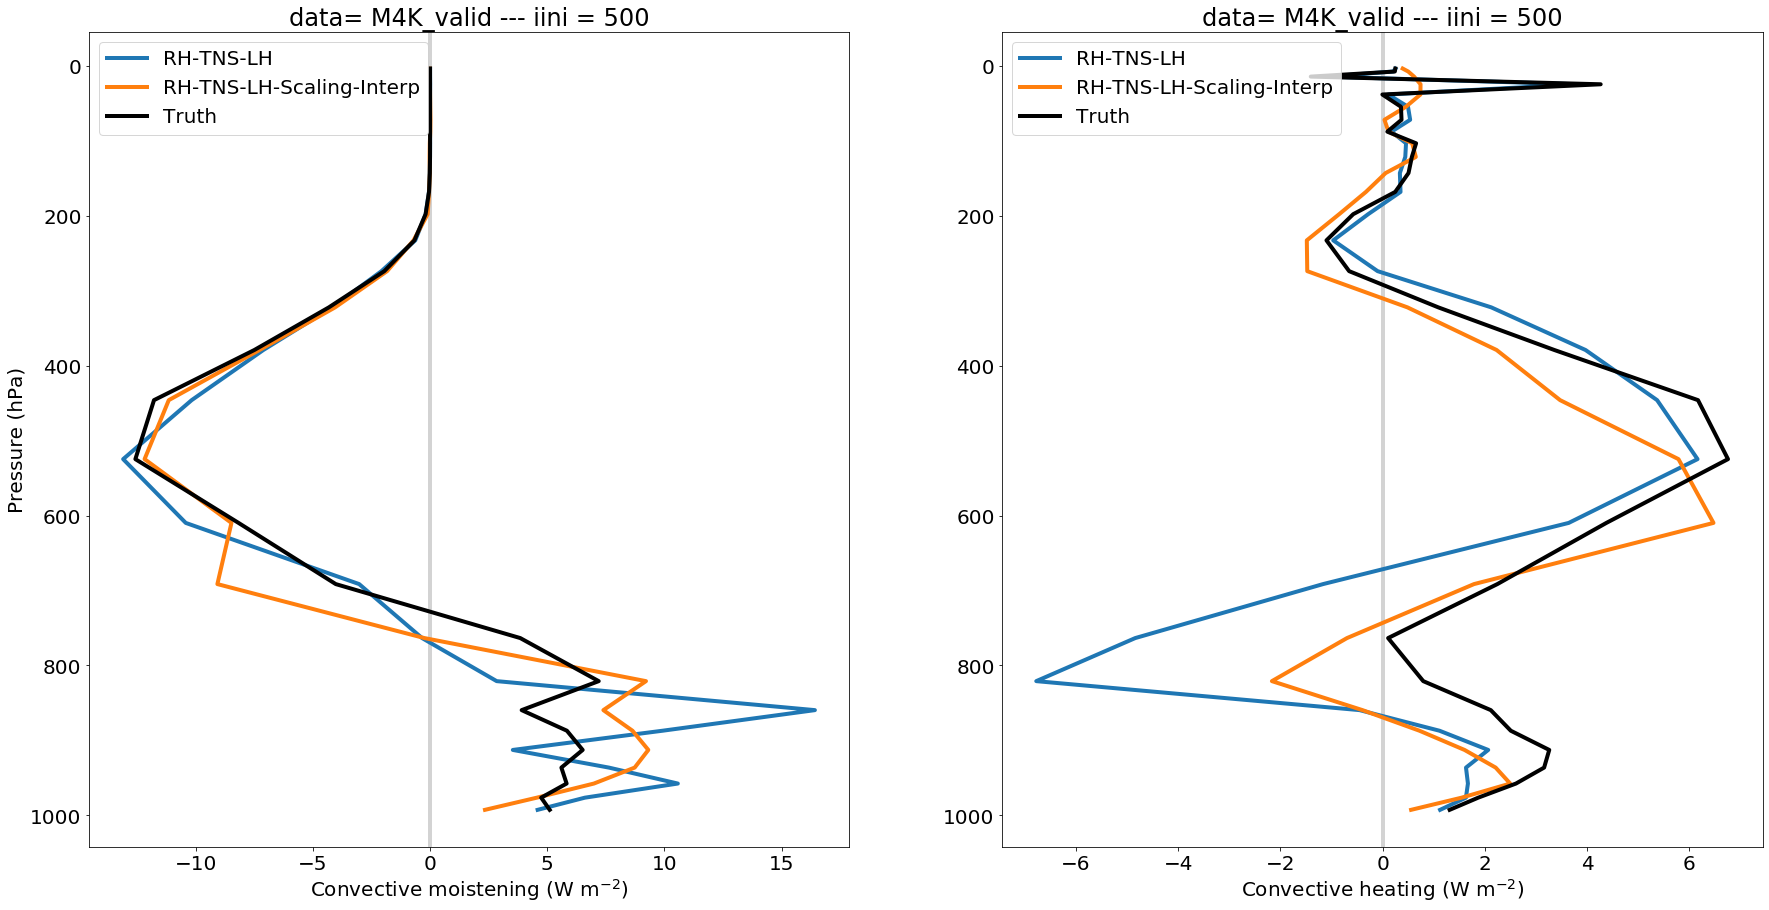

In [22]:


data = data_file[0][6:-3]
plt.figure(figsize=(30,15))
iini = iinis[0]
plt.subplot(1,2,1)
print(NNname)

plt.axvline(x=0,c='lightgray')
for iNN,NNs in enumerate(NNarray):
    plt.plot(np.mean(diagno[NNs][data][iini]['PHQ'],axis=(0,1,3)),lev,label=NNname[iNN])
plt.plot(np.mean(diagno['truth'][data][iini]['PHQ'],axis=(0,1,3)),lev,label='Truth',color='k')
plt.legend(loc="upper left")
plt.xlabel('Convective moistening ($\mathrm{W\ m^{-2}}$)')
plt.ylabel('Pressure (hPa)')
plt.gca().invert_yaxis()
plt.title('data= '+data+' '+ '--- iini = '+str(iini))


plt.subplot(1,2,2)
plt.axvline(x=0,c='lightgray')
for iNN,NNs in enumerate(NNarray):
    plt.plot(np.mean(diagno[NNs][data][iini]['TPHYSTND'],axis=(0,1,3)),lev,label=NNname[iNN])
plt.plot(np.mean(diagno['truth'][data][iini]['TPHYSTND'],axis=(0,1,3)),lev,label='Truth',color='k')
plt.legend(loc="upper left")
plt.xlabel('Convective heating ($\mathrm{W\ m^{-2}}$)')
plt.title('data= '+data+' '+ '--- iini = '+str(iini))
plt.gca().invert_yaxis()


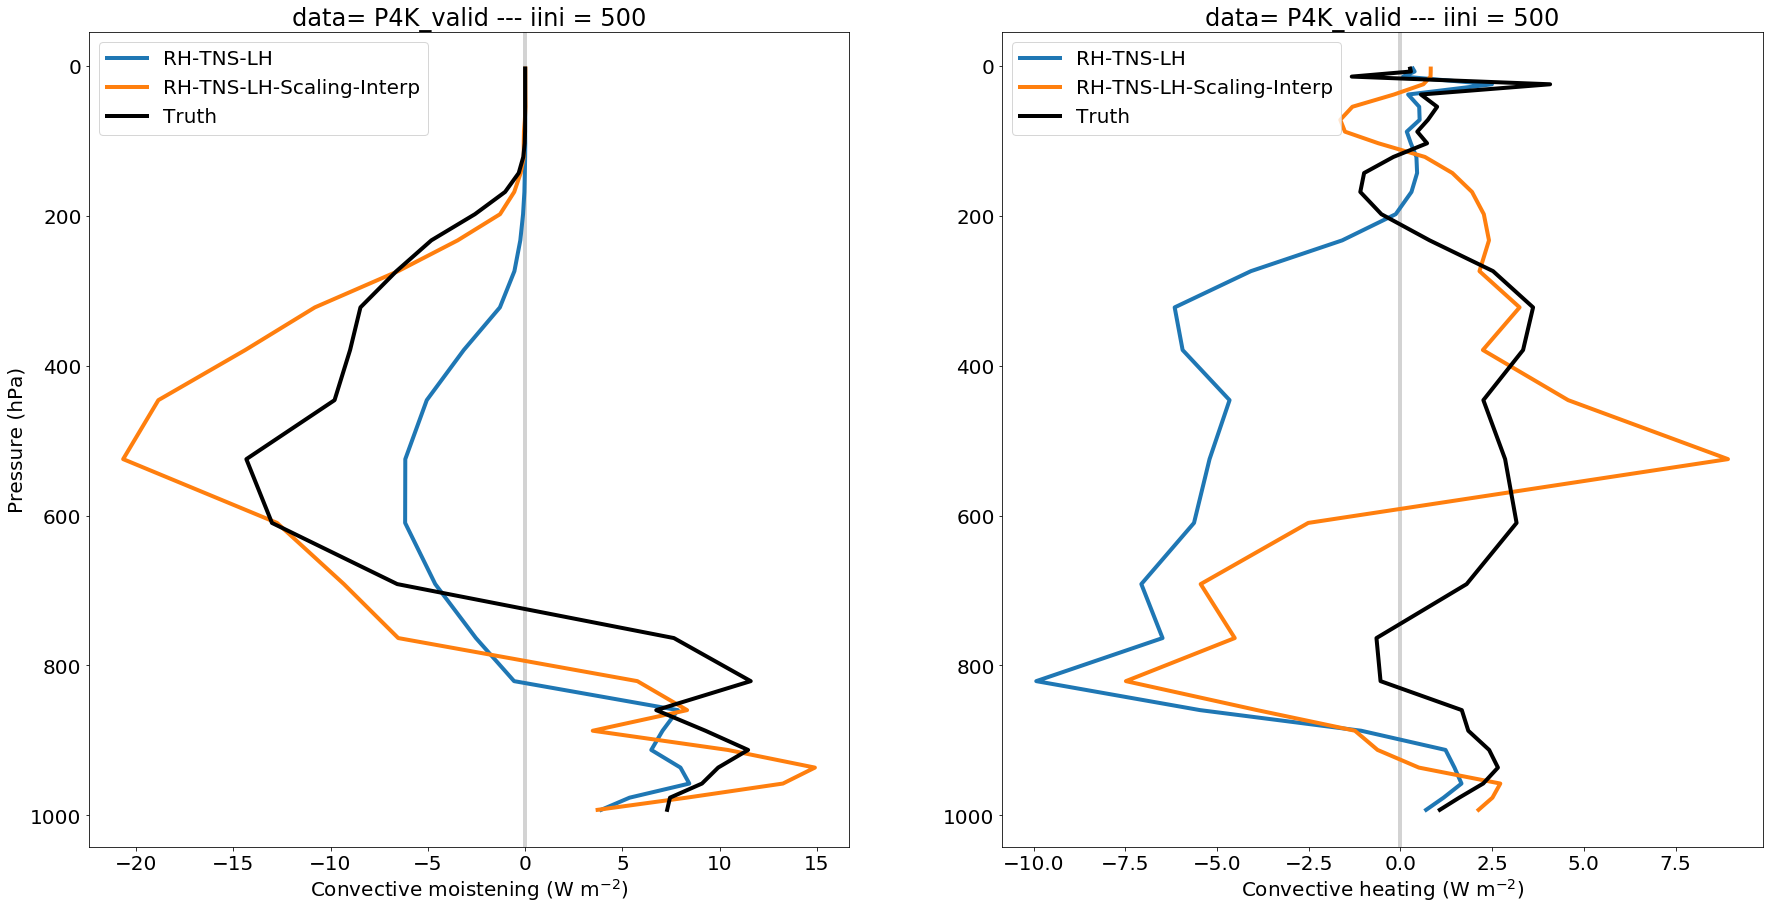

In [23]:


data = data_file[1][6:-3]
plt.figure(figsize=(30,15))
iini = iinis[0]
plt.subplot(1,2,1)
plt.axvline(x=0,c='lightgray')
for iNN,NNs in enumerate(NNarray):
    plt.plot(np.mean(diagno[NNs][data][iini]['PHQ'],axis=(0,1,3)),lev,label=NNname[iNN])
plt.plot(np.mean(diagno['truth'][data][iini]['PHQ'],axis=(0,1,3)),lev,label='Truth',color='k')
plt.legend(loc="upper left")
plt.xlabel('Convective moistening ($\mathrm{W\ m^{-2}}$)')
plt.ylabel('Pressure (hPa)')
plt.gca().invert_yaxis()
plt.title('data= '+data+' '+ '--- iini = '+str(iini))


plt.subplot(1,2,2)
plt.axvline(x=0,c='lightgray')
for iNN,NNs in enumerate(NNarray):
    plt.plot(np.mean(diagno[NNs][data][iini]['TPHYSTND'],axis=(0,1,3)),lev,label=NNname[iNN])
plt.plot(np.mean(diagno['truth'][data][iini]['TPHYSTND'],axis=(0,1,3)),lev,label='Truth',color='k')
plt.legend(loc="upper left")
plt.xlabel('Convective heating ($\mathrm{W\ m^{-2}}$)')
plt.title('data= '+data+' '+ '--- iini = '+str(iini))
plt.gca().invert_yaxis()


### If scaling is present (both the network can be visualized)

(14, 128, 30, 47)


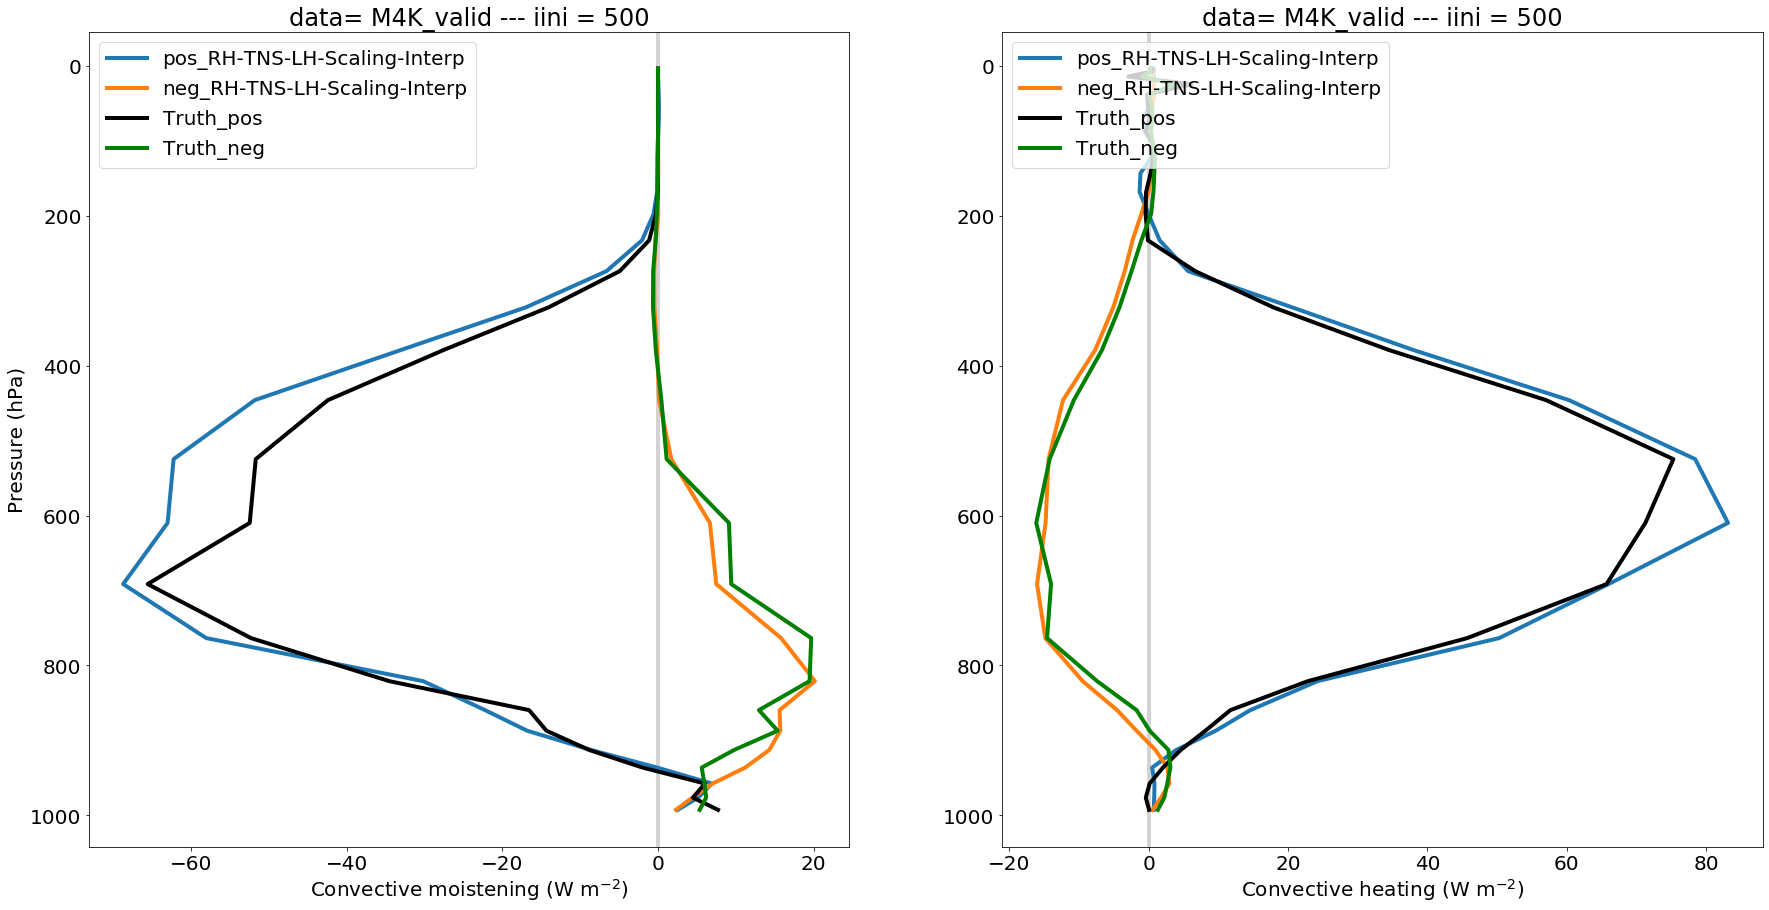

In [24]:
data = data_file[0][6:-3]

if truth_done[data]:
    plt.figure(figsize=(30,15))
    iini = iinis[-1]
    plt.subplot(1,2,1)
    plt.axvline(x=0,c='lightgray')
    for iNN,NNs in enumerate(NNarray):
        if NN[NNs].scaling==True:
            plt.plot(np.mean(diagno[NNs][data][iini]['PHQ_pos'],axis=0),lev,label='pos_'+NNname[iNN])
            plt.plot(np.mean(diagno[NNs][data][iini]['PHQ_neg'],axis=0),lev,label='neg_'+NNname[iNN])


    plt.plot(np.mean(diagno['truth_pos'][data][iini]['PHQ_pos'],axis=0),lev,label='Truth_pos',color='k')
    plt.plot(np.mean(diagno['truth_neg'][data][iini]['PHQ_neg'],axis=0),lev,label='Truth_neg',color='g')

    plt.legend(loc="upper left")
    plt.xlabel('Convective moistening ($\mathrm{W\ m^{-2}}$)')
    plt.ylabel('Pressure (hPa)')
    plt.gca().invert_yaxis()
    plt.title('data= '+data+' '+ '--- iini = '+str(iini))


    print(diagno[NNs][data][iini]['TPHYSTND'].shape)
    plt.subplot(1,2,2)
    plt.axvline(x=0,c='lightgray')
    for iNN,NNs in enumerate(NNarray):
        if NN[NNs].scaling==True:
            plt.plot(np.mean(diagno[NNs][data][iini]['TPHYSTND_pos'],axis=0),lev,label='pos_'+NNname[iNN])
            plt.plot(np.mean(diagno[NNs][data][iini]['TPHYSTND_neg'],axis=0),lev,label='neg_'+NNname[iNN])

    plt.plot(np.mean(diagno['truth_pos'][data][iini]['TPHYSTND_pos'],axis=0),lev,label='Truth_pos',color='k')
    plt.plot(np.mean(diagno['truth_neg'][data][iini]['TPHYSTND_neg'],axis=0),lev,label='Truth_neg',color='g')

    plt.legend(loc="upper left")
    plt.xlabel('Convective heating ($\mathrm{W\ m^{-2}}$)')
    plt.title('data= '+data+' '+ '--- iini = '+str(iini))
    plt.gca().invert_yaxis()

(14, 128, 30, 47)


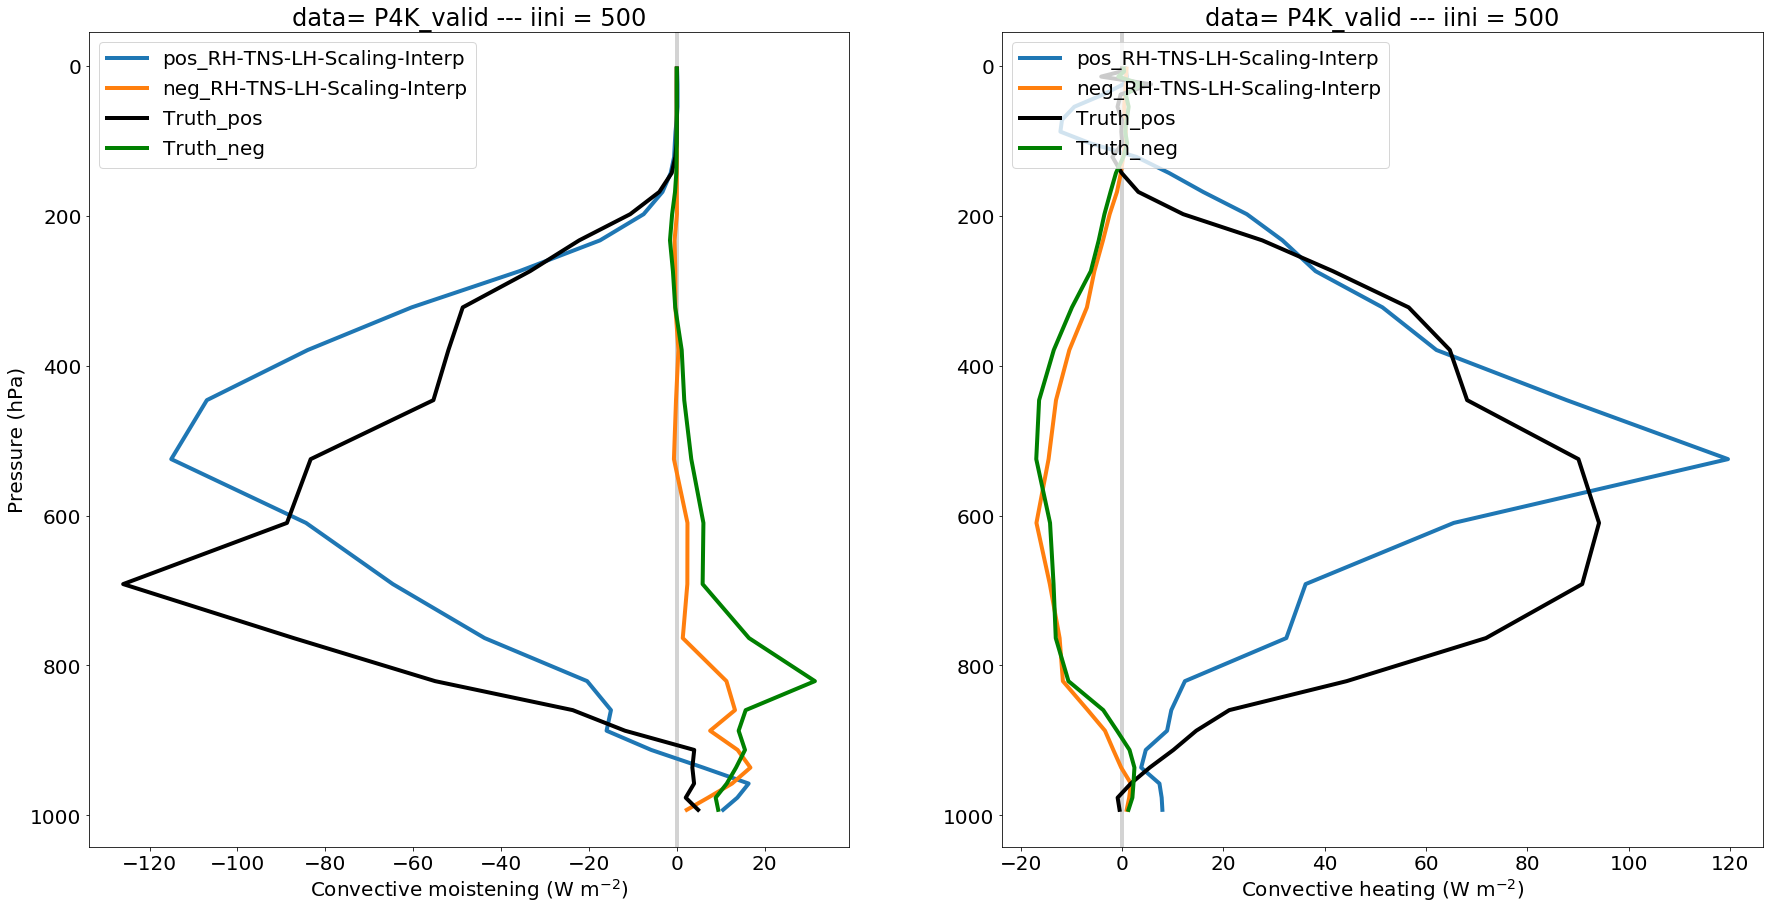

In [25]:
data = data_file[1][6:-3]


if truth_done[data]:
    plt.figure(figsize=(30,15))
    iini = iinis[-1]
    plt.subplot(1,2,1)
    plt.axvline(x=0,c='lightgray')
    for iNN,NNs in enumerate(NNarray):
        if NN[NNs].scaling==True:
            plt.plot(np.mean(diagno[NNs][data][iini]['PHQ_pos'],axis=0),lev,label='pos_'+NNname[iNN])
            plt.plot(np.mean(diagno[NNs][data][iini]['PHQ_neg'],axis=0),lev,label='neg_'+NNname[iNN])


    plt.plot(np.mean(diagno['truth_pos'][data][iini]['PHQ_pos'],axis=0),lev,label='Truth_pos',color='k')
    plt.plot(np.mean(diagno['truth_neg'][data][iini]['PHQ_neg'],axis=0),lev,label='Truth_neg',color='g')

    plt.legend(loc="upper left")
    plt.xlabel('Convective moistening ($\mathrm{W\ m^{-2}}$)')
    plt.ylabel('Pressure (hPa)')
    plt.gca().invert_yaxis()
    plt.title('data= '+data+' '+ '--- iini = '+str(iini))


    print(diagno[NNs][data][iini]['TPHYSTND'].shape)
    plt.subplot(1,2,2)
    plt.axvline(x=0,c='lightgray')
    for iNN,NNs in enumerate(NNarray):
        if NN[NNs].scaling==True:
            plt.plot(np.mean(diagno[NNs][data][iini]['TPHYSTND_pos'],axis=0),lev,label='pos_'+NNname[iNN])
            plt.plot(np.mean(diagno[NNs][data][iini]['TPHYSTND_neg'],axis=0),lev,label='neg_'+NNname[iNN])

    plt.plot(np.mean(diagno['truth_pos'][data][iini]['TPHYSTND_pos'],axis=0),lev,label='Truth_pos',color='k')
    plt.plot(np.mean(diagno['truth_neg'][data][iini]['TPHYSTND_neg'],axis=0),lev,label='Truth_neg',color='g')

    plt.legend(loc="upper left")
    plt.xlabel('Convective heating ($\mathrm{W\ m^{-2}}$)')
    plt.title('data= '+data+' '+ '--- iini = '+str(iini))
    plt.gca().invert_yaxis()